In [47]:
import pandas as pd 
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, DateTime
from sqlalchemy.dialects.sqlite import DATETIME

In [48]:
df = pd.read_csv('../Resources/collision_2022.csv')

In [49]:
df = df.drop_duplicates(subset=['collision_id'], keep='first').set_index('collision_id')

In [50]:
df['zip_code'] = df['zip_code'].astype(str)

In [51]:
df['crash_datetime'] = pd.to_datetime(df['crash_datetime'])

In [52]:
df.drop(columns='location', inplace=True)

In [53]:
df.rename(columns={'vehicle_type_code1': 'vehicle_type_code_1', 'vehicle_type_code2':'vehicle_type_code_2'}, inplace=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103789 entries, 4513547 to 4648224
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   crash_datetime                 103789 non-null  datetime64[ns]
 1   crash_day_of_week              103789 non-null  int64         
 2   street_address                 103787 non-null  object        
 3   number_of_persons_injured      103789 non-null  int64         
 4   number_of_persons_killed       103789 non-null  int64         
 5   number_of_pedestrians_injured  103789 non-null  int64         
 6   number_of_pedestrians_killed   103789 non-null  int64         
 7   number_of_cyclist_injured      103789 non-null  int64         
 8   number_of_cyclist_killed       103789 non-null  int64         
 9   number_of_motorist_injured     103789 non-null  int64         
 10  number_of_motorist_killed      103789 non-null  int64         
 11

In [55]:
import requests
import pandas as pd

# Fetch data from the API
additional_columns = requests.get("https://data.cityofnewyork.us/resource/h9gi-nx95.json")
additional_columns_data = additional_columns.json()
additional_df = pd.DataFrame(additional_columns_data)
additional_df.set_index('collision_id', inplace=True)
additional_df.head(5)

,crash_date,crash_time,on_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,latitude,longitude,location,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
collision_id,,,,,,,,,,,,,,,,,,,,,
4455765,2021-09-11T00:00:00.000,2:39,WHITESTONE EXPRESSWAY,20 AVENUE,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4513547,2022-03-26T00:00:00.000,11:45,QUEENSBORO BRIDGE UPPER,NaN,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4541903,2022-06-29T00:00:00.000,6:55,THROGS NECK BRIDGE,NaN,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4456314,2021-09-11T00:00:00.000,9:35,NaN,NaN,0,0,0,0,0,0,...,40.667202,-73.8665,"{'latitude': '40.667202', 'longitude': '-73.86...",1211 LORING AVENUE,NaN,NaN,NaN,NaN,NaN,NaN
4486609,2021-12-14T00:00:00.000,8:13,SARATOGA AVENUE,DECATUR STREET,0,0,0,0,0,0,...,40.683304,-73.917274,"{'latitude': '40.683304', 'longitude': '-73.91...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
additional_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4455765 to 4407712
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   crash_date                     1000 non-null   object
 1   crash_time                     1000 non-null   object
 2   on_street_name                 742 non-null    object
 3   off_street_name                451 non-null    object
 4   number_of_persons_injured      1000 non-null   object
 5   number_of_persons_killed       1000 non-null   object
 6   number_of_pedestrians_injured  1000 non-null   object
 7   number_of_pedestrians_killed   1000 non-null   object
 8   number_of_cyclist_injured      1000 non-null   object
 9   number_of_cyclist_killed       1000 non-null   object
 10  number_of_motorist_injured     1000 non-null   object
 11  number_of_motorist_killed      1000 non-null   object
 12  contributing_factor_vehicle_1  997 non-null    object
 13 

In [57]:
df.index = df.index.astype(str)
additional_df.index = additional_df.index.astype(str)

In [58]:
# rename columns contributing_factor_vehicle to contributing_factor_vehicle_1 
df.rename(columns={'contributing_factor_vehicle':'contributing_factor_vehicle_1'}, inplace=True)

In [59]:
df['contributing_factor_vehicle_2'] = additional_df['contributing_factor_vehicle_2']
df['contributing_factor_vehicle_3'] = additional_df['contributing_factor_vehicle_3']
df['contributing_factor_vehicle_4'] = additional_df['contributing_factor_vehicle_4']
df['contributing_factor_vehicle_5'] = additional_df['contributing_factor_vehicle_5']

In [60]:
df['vehicle_type_code_1'] = additional_df['vehicle_type_code1']
df['vehicle_type_code_2'] = additional_df['vehicle_type_code2']
df['vehicle_type_code_3'] = additional_df['vehicle_type_code_3']
df['vehicle_type_code_4'] = additional_df['vehicle_type_code_4']
df['vehicle_type_code_5'] = additional_df['vehicle_type_code_5']

In [61]:
crash_datetime = df['crash_datetime']
df.drop(labels=['crash_datetime'], axis=1, inplace=True)
df.insert(0, 'crash_datetime', crash_datetime)

In [62]:
demo_df = pd.read_excel('../Resources/NewYork_DemographicsByZipCode.xlsx')
demo_df = demo_df.iloc[3:]
demo_df = demo_df.rename(columns={'Geography': 'zip_code'}, inplace=False)
demo_df = demo_df.rename(columns={'Best Population Estimate': 'Population'}, inplace=False)
demo_df = demo_df.rename(columns={demo_df.columns[7]: 'Population Density'}, inplace=False)
demo_df = demo_df[(demo_df['zip_code'] != "New York") & (demo_df['zip_code'] != "name")]
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 5 to 1830
Data columns (total 67 columns):
 #   Column                                                                       Non-Null Count  Dtype 
---  ------                                                                       --------------  ----- 
 0   zip_code                                                                     1826 non-null   object
 1   GEOID                                                                        1826 non-null   object
 2   State                                                                        1826 non-null   object
 3   County                                                                       5 non-null      object
 4   City                                                                         5 non-null      object
 5   Best Population Year                                                         1826 non-null   object
 6   Population                                           

In [63]:
demo_df = demo_df[['zip_code','Population']].reset_index(drop=True)
demo_df.head()

,zip_code,Population
0,06390,58
1,10001,26966
2,10002,76807
3,10003,54447
4,10004,4795


In [64]:
df = df.reset_index().merge(demo_df, on='zip_code', how='left').set_index('collision_id')
df["Population"] = df["Population"].astype("float")
df.head()

,crash_datetime,crash_day_of_week,street_address,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,...,zip_code,latitude,longitude,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5,Population
collision_id,,,,,,,,,,,,,,,,,,,,,
4513547,2022-03-26 11:45:00,5,Queensboro Bridge Upper,1,0,0,0,0,0,1,...,10044,40.756929,-73.954755,NaN,NaN,NaN,NaN,NaN,NaN,12155.0
4541903,2022-06-29 06:55:00,2,Throgs Neck Bridge,0,0,0,0,0,0,0,...,10465,40.805080,-73.793780,NaN,NaN,NaN,NaN,NaN,NaN,46205.0
4542336,2022-06-29 16:00:00,2,Williamsburg Bridge Outer Roadwa,1,0,0,0,0,0,1,...,11211,40.713595,-73.971962,NaN,NaN,NaN,NaN,NaN,NaN,65925.0
4545699,2022-07-12 17:50:00,1,44 Empire Boulevard,0,0,0,0,0,0,0,...,11225,40.663303,-73.960490,NaN,NaN,NaN,NaN,NaN,NaN,59465.0
4512922,2022-03-23 10:00:00,2,71 East Drive,0,0,0,0,0,0,0,...,11225,40.661927,-73.964893,NaN,NaN,NaN,NaN,NaN,NaN,59465.0


In [65]:
collision_by_zip_df = df.groupby('zip_code').size()
collision_by_zip_df = collision_by_zip_df.reset_index().rename(columns={"zip_code":"zipcodes",0:"# of Collisions"})
collision_by_zip_df['# of Collisions'] = collision_by_zip_df['# of Collisions'].astype('int')
collision_by_zip_df['zipcodes'] = collision_by_zip_df['zipcodes'].astype('str')
collision_by_zip_df.set_index('zipcodes', inplace=True)
collision_by_zip_df.head()

,# of Collisions
zipcodes,
10000,30
10001,590
10002,880
10003,415
10004,89


In [66]:
## add an attribute that classifies the hour of the day
df["crash_hour"] = df['crash_datetime'].dt.hour

def classify_hour(hour):
    if 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 10 or 15 <= hour < 20:
        return 'Rush Hours'
    elif 22 <= hour or hour < 4:
        return 'Late Night'
    else:
        return 'Other Hours'

df['crash_hour_category'] = df['crash_hour'].apply(classify_hour)    
df = df.drop('crash_hour', axis=1)
column_to_move = df.pop('crash_hour_category')
df.insert(2, 'crash_hour_category', column_to_move)
df.head()

,crash_datetime,crash_day_of_week,crash_hour_category,street_address,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,zip_code,latitude,longitude,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5,Population
collision_id,,,,,,,,,,,,,,,,,,,,,
4513547,2022-03-26 11:45:00,5,Other Hours,Queensboro Bridge Upper,1,0,0,0,0,0,...,10044,40.756929,-73.954755,NaN,NaN,NaN,NaN,NaN,NaN,12155.0
4541903,2022-06-29 06:55:00,2,Early Morning,Throgs Neck Bridge,0,0,0,0,0,0,...,10465,40.805080,-73.793780,NaN,NaN,NaN,NaN,NaN,NaN,46205.0
4542336,2022-06-29 16:00:00,2,Rush Hours,Williamsburg Bridge Outer Roadwa,1,0,0,0,0,0,...,11211,40.713595,-73.971962,NaN,NaN,NaN,NaN,NaN,NaN,65925.0
4545699,2022-07-12 17:50:00,1,Rush Hours,44 Empire Boulevard,0,0,0,0,0,0,...,11225,40.663303,-73.960490,NaN,NaN,NaN,NaN,NaN,NaN,59465.0
4512922,2022-03-23 10:00:00,2,Other Hours,71 East Drive,0,0,0,0,0,0,...,11225,40.661927,-73.964893,NaN,NaN,NaN,NaN,NaN,NaN,59465.0


In [67]:
## check for missing values:
# drop attributes of contributing factors that only have value "unspecified":
contributing_factor_columns = [
    'contributing_factor_vehicle_1',
    'contributing_factor_vehicle_2',
    'contributing_factor_vehicle_3',
    'contributing_factor_vehicle_4',
    'contributing_factor_vehicle_5'
]

# Check if all values in each contributing factor column are "Unspecified"
columns_to_drop = [col for col in contributing_factor_columns if all(df[col].dropna() == 'Unspecified')]

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

#drop attributes of which all the values are missing:
df.dropna(axis=1, how='all',inplace = True)



In [68]:
# combine the contributing factors into one attribute:
df["contributing_factor"] = df["contributing_factor_vehicle_1"]
df.drop(["contributing_factor_vehicle_1","contributing_factor_vehicle_2"],axis = 1,inplace= True)

In [69]:
df['zip_code'] = df['zip_code'].astype('str')
df[df['zip_code'].str.len() != 5]['zip_code']

collision_id
4524418         7514
4526434         7307
4527885         7006
4528539         7047
4562093    113541906
4585574         8721
4591216         7305
4591962         8721
Name: zip_code, dtype: object

In [70]:
df.loc[df['zip_code'] == '113541906','zip_code'] = "11354"

In [71]:
## drop the rows that have four-digit zip code
df.drop(df[df['zip_code'].str.len() != 5].index, inplace = True)
df

,crash_datetime,crash_day_of_week,crash_hour_category,street_address,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,...,vehicle_type_code_1,vehicle_type_code_2,borough,zip_code,latitude,longitude,vehicle_type_code_3,vehicle_type_code_4,Population,contributing_factor
collision_id,,,,,,,,,,,,,,,,,,,,,
4513547,2022-03-26 11:45:00,5,Other Hours,Queensboro Bridge Upper,1,0,0,0,0,0,...,Sedan,NaN,NaN,10044,40.756929,-73.954755,NaN,NaN,12155.0,Pavement Slippery
4541903,2022-06-29 06:55:00,2,Early Morning,Throgs Neck Bridge,0,0,0,0,0,0,...,Sedan,Pick-up Truck,NaN,10465,40.805080,-73.793780,NaN,NaN,46205.0,Following Too Closely
4542336,2022-06-29 16:00:00,2,Rush Hours,Williamsburg Bridge Outer Roadwa,1,0,0,0,0,0,...,Motorscooter,Station Wagon/Sport Utility Vehicle,NaN,11211,40.713595,-73.971962,NaN,NaN,65925.0,Driver Inattention/Distraction
4545699,2022-07-12 17:50:00,1,Rush Hours,44 Empire Boulevard,0,0,0,0,0,0,...,Sedan,NaN,Brooklyn,11225,40.663303,-73.960490,NaN,NaN,59465.0,Oversized Vehicle
4512922,2022-03-23 10:00:00,2,Other Hours,71 East Drive,0,0,0,0,0,0,...,Bike,NaN,NaN,11225,40.661927,-73.964893,NaN,NaN,59465.0,Pedestrian/Bicyclist/Other Pedestrian Error/Co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4647581,2022-09-15 19:49:00,3,Rush Hours,East New York Avenue & Rockaway Parkway,0,0,0,0,0,0,...,NaN,NaN,Brooklyn,11213,40.665916,-73.925470,NaN,NaN,69392.0,Driver Inattention/Distraction
4647839,2022-07-21 22:05:00,3,Late Night,Cross Island Parkway,0,0,0,0,0,0,...,NaN,NaN,NaN,11411,40.697162,-73.727529,NaN,NaN,21605.0,Unspecified
4647650,2022-12-31 02:00:00,5,Late Night,Tilden Avenue,1,0,0,0,0,0,...,NaN,NaN,NaN,11203,40.647121,-73.943381,NaN,NaN,79499.0,Traffic Control Disregarded


In [72]:
df["number_of_injuries"] = df["number_of_cyclist_injured"] + df["number_of_motorist_injured"] + df["number_of_pedestrians_injured"] + df["number_of_persons_injured"]
df["number_of_deaths"] = df["number_of_cyclist_killed"] + df["number_of_motorist_killed"] + df["number_of_pedestrians_killed"] + df["number_of_persons_killed"]
df["injuries_rate"] = df["number_of_injuries"]/df["Population"]
df["death_rate"] = df["number_of_deaths"] /df["Population"]

In [73]:
# create a result table that records every count of injuries & deaths combination 
injuries_deaths_df = df.groupby(["number_of_injuries", "number_of_deaths","death_rate","injuries_rate"]).size().reset_index(name='count')
injuries_deaths_df["total_involved"] = injuries_deaths_df["number_of_deaths"] + injuries_deaths_df["number_of_injuries"]
injuries_deaths_df

,number_of_injuries,number_of_deaths,death_rate,injuries_rate,count,total_involved
0,0,0,0.000000,0.000000,64393,0
1,0,1,0.000011,0.000000,2,1
2,0,1,0.000011,0.000000,3,1
3,0,1,0.000012,0.000000,1,1
4,0,1,0.000012,0.000000,1,1
...,...,...,...,...,...,...
1280,28,0,0.000000,0.002475,1,28
1281,30,0,0.000000,0.000301,1,30
1282,30,0,0.000000,0.000377,1,30
1283,30,0,0.000000,0.000674,1,30


In [74]:
injuries_deaths_df[injuries_deaths_df['total_involved']>0]

,number_of_injuries,number_of_deaths,death_rate,injuries_rate,count,total_involved
1,0,1,0.000011,0.000000,2,1
2,0,1,0.000011,0.000000,3,1
3,0,1,0.000012,0.000000,1,1
4,0,1,0.000012,0.000000,1,1
5,0,1,0.000012,0.000000,1,1
...,...,...,...,...,...,...
1280,28,0,0.000000,0.002475,1,28
1281,30,0,0.000000,0.000301,1,30
1282,30,0,0.000000,0.000377,1,30
1283,30,0,0.000000,0.000674,1,30


In [75]:
# redefine the severity of accidents
def categorize_severity(row):
    if row['number_of_deaths'] >= 4:
        return 'Very Fatal'
    elif row['number_of_deaths'] > 0:
        return 'Fatal'
    elif row['number_of_injuries'] >= 10:
        return 'Serious (High)'
    elif row['number_of_injuries'] >= 5:
        return 'Serious (Medium)'
    elif row['number_of_injuries'] > 0:
        return 'Serious (Low)'
    else:
        return 'Minor'

# Apply the function to create a new column 'severity_of_accident'
df['severity_of_accident'] = df.apply(categorize_severity, axis=1)

# Display the resulting DataFrame
print(df[['number_of_injuries', 'number_of_deaths', 'severity_of_accident']])

              number_of_injuries  number_of_deaths severity_of_accident
collision_id                                                           
4513547                        2                 0        Serious (Low)
4541903                        0                 0                Minor
4542336                        2                 0        Serious (Low)
4545699                        0                 0                Minor
4512922                        0                 0                Minor
...                          ...               ...                  ...
4647581                        0                 0                Minor
4647839                        0                 0                Minor
4647650                        2                 0        Serious (Low)
4648107                        0                 0                Minor
4648224                        0                 0                Minor

[103782 rows x 3 columns]


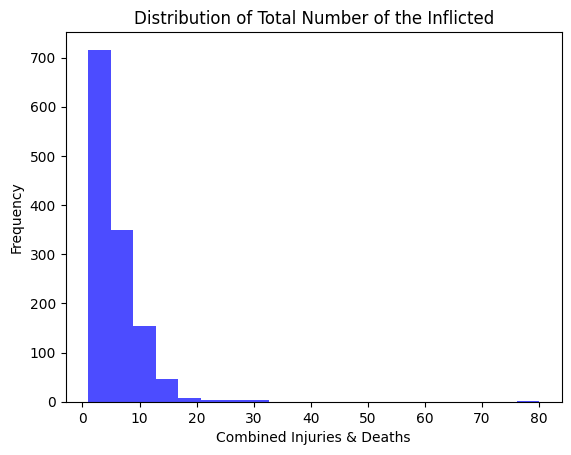

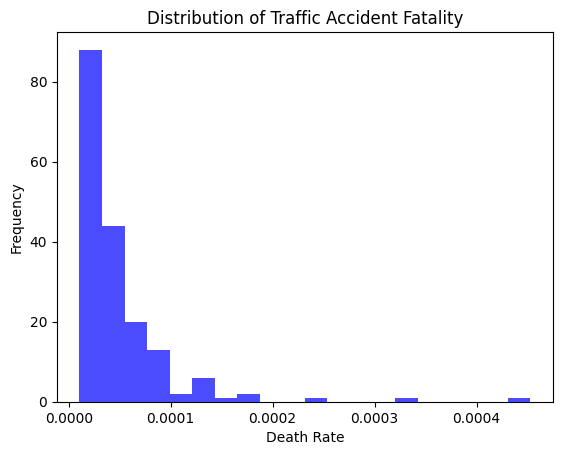

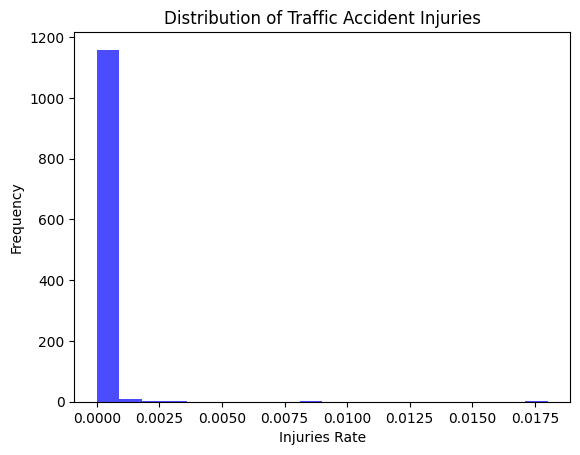

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a histogram to visualize the distribution of the injuries and deaths combo that are greater than 0
plt.hist(injuries_deaths_df['total_involved'][injuries_deaths_df['total_involved']>0], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Total Number of the Inflicted')
plt.xlabel('Combined Injuries & Deaths')
plt.ylabel('Frequency')
plt.show()

# Create a histogram to visualize the distribution of the death_rate of the cases with injuries rate greater than 0
plt.hist(injuries_deaths_df['death_rate'][injuries_deaths_df['death_rate']>0], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Traffic Accident Fatality')
plt.xlabel('Death Rate')
plt.ylabel('Frequency')
plt.show()

# Create a histogram to visualize the distribution of the injuries_rate of the cases with injuries rate greater than 0
plt.hist(injuries_deaths_df['injuries_rate'][injuries_deaths_df['injuries_rate']>0], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Traffic Accident Injuries')
plt.xlabel('Injuries Rate')
plt.ylabel('Frequency')
plt.show()



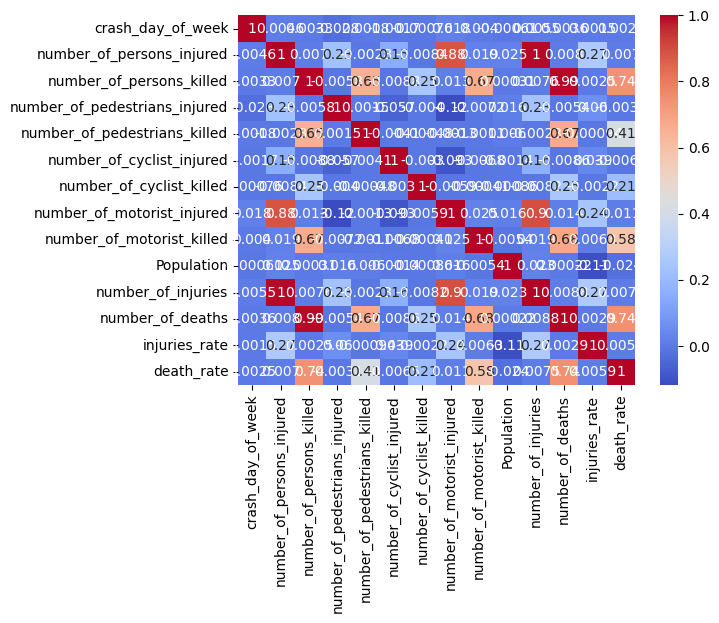

In [78]:
# correlation matrix
import seaborn as sns
columns_to_keep = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = columns_to_keep.drop(["latitude", "longitude"], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


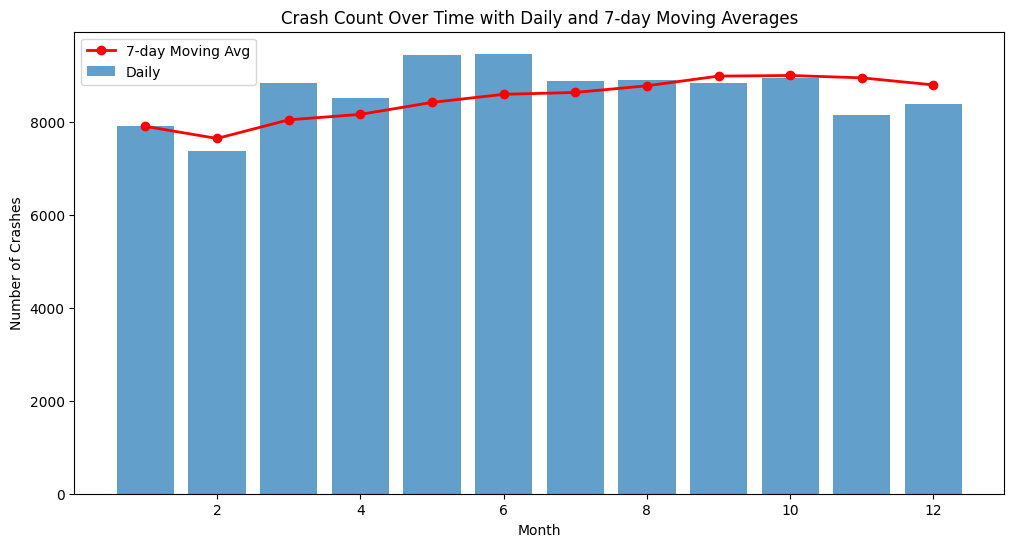

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract month and year from the datetime
df['month'] = df['crash_datetime'].dt.month
df['year'] = df['crash_datetime'].dt.year

# Create a pivot table to count the number of crashes per month and year
seasonality_data = df.pivot_table(index='month', columns='year', values='crash_datetime', aggfunc='count')

# Calculate the daily moving average
daily_moving_avg = seasonality_data.rolling(window=30, min_periods=1).mean()

# Calculate the weekly moving average
weekly_moving_avg = seasonality_data.rolling(window=7, min_periods=1).mean()

# Plot both daily and weekly moving averages in the same plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(seasonality_data.index, seasonality_data.mean(axis=1), label='Daily', alpha=0.7)
ax.plot(weekly_moving_avg.index, weekly_moving_avg.mean(axis=1), marker='o',color='red', label='7-day Moving Avg', linewidth=2)

ax.set_title('Crash Count Over Time with Daily and 7-day Moving Averages')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Crashes')
ax.legend()

plt.show()


In [80]:
import json

# Define the file path
file_path = '../Resources/nyc_geojson_by_zip.json'

# Open the file and load the GeoJSON data
with open(file_path, 'r') as file:
    geojson_data = json.load(file)

In [81]:
# add the collision count to the geojson data
for feature in geojson_data['features']:
    zipcode = feature['properties']['postalCode']
    if zipcode in collision_by_zip_df.index:
        feature['properties']['collision_count'] = collision_by_zip_df.loc[zipcode]['# of Collisions']
    else:
        feature['properties']['collision_count'] = 0

In [82]:
import numpy as np
# Custom function to handle non-serializable data types
def convert(o):
    if isinstance(o, np.integer):
        return int(o)
    raise TypeError

# Use json.dump with the custom function to handle non-serializable data
with open('../static/data/nyc_geojson_by_zip_with_counts.json', 'w') as file:
    json.dump(geojson_data, file, default=convert)

In [83]:
df.to_csv('../Resources/collision_2022_classified.csv', index=False)

In [86]:
engine = create_engine('sqlite:///../Resources/collision_db.sqlite')

In [87]:
metadata = MetaData()

In [91]:
motor_collisions = Table('motor_collisions', metadata,
                         Column('collision_id', Integer, primary_key=True),
                         Column('crash_datetime', DateTime),
                         Column('crash_day_of_week', Integer),
                         Column('crash_hour_category', String),
                         Column('street_address', String), 
                         Column('borough', String),
                         Column('zip_code', String),
                         Column('latitude', Float),
                         Column('longitude', Float),
                         Column('number_of_persons_injured', Integer),
                         Column('number_of_persons_killed', Integer),
                         Column('number_of_pedestrians_injured', Integer),
                         Column('number_of_pedestrians_killed', Integer),
                         Column('number_of_cyclist_injured', Integer),
                         Column('number_of_cyclist_killed', Integer),
                         Column('number_of_motorist_injured', Integer),
                         Column('number_of_motorist_killed', Integer),
                         Column('contributing_factor', String),
                         Column('number_of_injuries', Integer),
                         Column('number_of_deaths', Integer),
                         Column('vehicle_type_code_1', String),
                         Column('vehicle_type_code_2', String),
                         Column('vehicle_type_code_3', String),
                         Column('vehicle_type_code_4', String),
                         Column('injuries_rate', Float),
                         Column('death_rate', Float),
                         Column('severity_of_accident', String),
                         Column('Population', Float)
                         )
metadata.create_all(engine)

In [92]:
df.to_sql('motor_collisions', con=engine, if_exists='append', index=True)

103782

In [93]:
from sqlalchemy import inspect

inspector = inspect(engine)
print(inspector.get_table_names())  # Check if the table is listed
print(inspector.get_columns('motor_collisions'))  # Check the structure of the table


['motor_collisions', 'weather_2022_info']
[{'name': 'collision_id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}, {'name': 'crash_datetime', 'type': DATETIME(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'crash_day_of_week', 'type': INTEGER(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'crash_hour_category', 'type': VARCHAR(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'street_address', 'type': VARCHAR(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'borough', 'type': VARCHAR(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'zip_code', 'type': VARCHAR(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}, {'name': 'number_of_persons_injured', 'type': INTEGER(), 'nullable': True, 'd

In [ ]:
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['collision_by_zip', 'motor_collisions', 'weather_2022_info']